# Import Library

In [1]:
import copy
import pickle
import os


import matplotlib.pyplot as plt
import numpy as np
from numpy import random
from scipy.integrate import solve_ivp
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn import datasets
from sklearn.datasets import load_digits
from torch.utils.data import random_split
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import ToTensor
from torchvision.datasets import FashionMNIST



EPS = 1.0e-7

# Import Dataset

In [2]:
# pull drive folder 
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [3]:
# save directory
results_dir = "/content/gdrive/MyDrive/Computational_Intelligence/"


Dataset

The Dataset contains 2 sets: train set (60000 points) and test set (10000 points)

I would split the train set into 2 subsets: training(50000) and validation(10000)

In [4]:
class Digits(Dataset):
    """Scikit-Learn Digits dataset."""

    def __init__(self, mode="train", transforms=None):
        digits = load_digits() # import dataset
        # load digits would contain some parameter
        # data (1797,64)
        # targets (1797,)
        if mode == "train":
            # 55% for training
            self.data = digits.data[:1000].astype(np.float32)
            self.data = np.reshape(self.data,(self.data.shape[0],1,8,8))
            self.targets = digits.target[:1000]
        elif mode == "val":
            # 20% (350 points) for validation
            self.data = digits.data[1000:1350].astype(np.float32)
            self.data = np.reshape(self.data,(self.data.shape[0],1,8,8))
            self.targets = digits.target[1000:1350]
        else:
            # rest for testing
            self.data = digits.data[1350:].astype(np.float32)
            self.data = np.reshape(self.data,(self.data.shape[0],1,8,8))
            self.targets = digits.target[1350:]

        self.transforms = transforms

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample_x = self.data[idx]
        sample_y = self.targets[idx]
        if self.transforms:
            sample_x = self.transforms(sample_x)
        return (sample_x, sample_y)

In [5]:
# Initialize training, validation and test sets.
train_data = Digits(mode="train")
val_data = Digits(mode="val")
test_data = Digits(mode="test")

# Initialize data loaders.
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)


**Usage of CUDA**

Due to the beneficial usage of CUDA in training time, the project would switch to use the resource in case it is available

In [6]:
# The function would prioritize using CUDA
# if it is available
# otherwise, the model is normally trained with CPU
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')


# The function would move all the data structure or model
# under the platform which is processed by the given device
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    # transform for model
    return data.to(device, non_blocking=True)

# The new DataLoader 
# which tranforms the normal DataLoader into the loader using the given device
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

# get device
device = get_default_device()

# change DataLoader type
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
test_loader = DeviceDataLoader(test_loader, device)

# Visualization

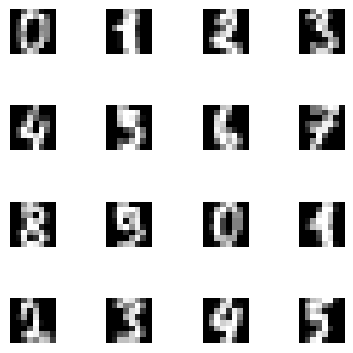

In [7]:
digits = load_digits()
x = digits.data[:16].astype(np.float32)

fig_data, axs = plt.subplots(4, 4, figsize=(4, 4))
fig_data.tight_layout()

for i in range(4):
    for j in range(4):
        # reshape image from a vector 
        # to a 8x8 tensor
        img = np.reshape(x[4 * i + j], (8, 8))
        axs[i, j].imshow(img, cmap="gray")
        axs[i, j].axis("off")

# Model representation
A model vector would contain 6 elements representing the type of layers of the Convolutional Neural Network. The first element would present the type of Convolution layer is used in the model. The second element shows the type of non-linear activation function. The third element informs the type of pooling layer. Since the flattening layer has only one role of tranforms a feature map into a 1D vector, I would not define the layer here. Next, one linear hidden layer is arranged and followd by a non-linear activation function F2. Finally, the output would be come into another linear layer before being computed to the probabilities by the SoftMax function. Since the second hidden layer returns the probabilities over classes, I do not define the hyperparameter for the layer.

$$\mathbf{x} =[Conv2d, F1, Pooling, Linear1, F2] $$

# Define hyperparameter

In [8]:
# data hyperparams
D = 64  # batch size
K = 10 # classes


# model hyperparams
M = 256  # the number of neurons in scale (s) and translation (t) nets
bias = False
ld = 0.01 # lambda for evaluation
pop_size = 20 # population size


# -> training hyperparams
num_generations = 100 # generation
lr = 1e-3  # learning rate
wd = 1e-5  # weight decay
num_epochs = 20  # max. number of epochs
max_patience = 10  # an early stopping is used, if training doesn't improve for longer than 20 epochs, it is stopped


In [9]:
# Define all parameters for each layer of the model
params = {}
params["Conv2d"] = np.asarray([nn.Conv2d(1,8, kernel_size = (3,3), stride = 1, padding = 1),
                                 nn.Conv2d(1,8, kernel_size = (2,2), stride = 1, padding = 2),
                                 nn.Conv2d(1,16, kernel_size = (3,3), stride = 1, padding = 1),
                                 nn.Conv2d(1,16, kernel_size = (2,2), stride = 1, padding = 2),
                                 nn.Conv2d(1,32, kernel_size = (3,3), stride = 1, padding = 1),
                                 nn.Conv2d(1,32, kernel_size = (2,2), stride = 1, padding = 2)])
params["F1"] = np.asarray([nn.ReLU(), nn.Sigmoid(), nn.Tanh(), nn.Softplus(), nn.ELU()])
params["Pooling"] = np.asarray([nn.MaxPool2d(2), nn.AvgPool2d(2), nn.MaxPool2d(1), nn.AvgPool2d(1)])
params["Linear1"] = np.asarray([10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
params["F2"] = np.asarray([nn.ReLU(), nn.Sigmoid(), nn.Tanh(), nn.Softplus(), nn.ELU()])



# Evaluation

In [11]:
def evaluation(test_loader,name=None, model_best=None, epoch=None):
    # If available, load the best performing model
    if model_best is None:
        model_best = torch.load(name + ".model")
  
    # set the model to the evaluation mode
    model_best.eval()  
    loss_test = 0.0
    loss_error = 0.0
    N = 0.0
    
    # start evaluation
    for indx_batch, (test_batch, test_targets) in enumerate(test_loader):
        # loss (nll)
        loss_test_batch = model_best.forward(test_batch, test_targets, reduction="sum")
        # tensor.item() returns a tensor of 1 element into 
        # a standard Python nhmber
        loss_test = loss_test + loss_test_batch.item()
        # classification error
        y_pred = model_best.classify(test_batch)
        e = 1.0 * (y_pred == test_targets)
        loss_error = loss_error + (1.0 - e).sum().item()
        # the number of examples
        N = N + test_batch.shape[0]
    # divide by the number of examples
    loss_test = loss_test / N
    loss_error = loss_error / N

    # Uncomment to see the evaluation on models
    '''# Print the performance
    if epoch is None:
        print(f"-> FINAL PERFORMANCE: nll={loss_test}, ce={loss_error}")
    else:
        if epoch % 2 == 0:
            print(f"Epoch: {epoch}, val nll={loss_test}, val ce={loss_error}")'''

    return loss_test, loss_error


# Training Procedure

In [12]:
def training(name, max_patience, num_epochs, model, optimizer, training_loader, val_loader):
    nll_val = []
    error_val = []
    best_nll = 1000.0
    patience = 0

    # Main training loop
    for e in range(num_epochs):
        # set the model to the training mode
        model.train()  

        # load batches
        for indx_batch, (batch, targets) in enumerate(training_loader):
            # calculate the forward pass (loss function for given images and labels)
            loss = model.forward(batch, targets)
            # remember we need to zero gradients! Just in case!
            optimizer.zero_grad()
            # calculate backward pass
            loss.backward(retain_graph=True)
            # run the optimizer
            optimizer.step()

        # Validation: Evaluate the model on the validation data
        loss_e, error_e = evaluation(val_loader, model_best=model, epoch=e)
        nll_val.append(loss_e)  # save for plotting
        error_val.append(error_e)  # save for plotting

        # Early-stopping: update the best performing model and break training if no
        # progress is observed.
        if e == 0:
            torch.save(model, name + ".model")
            best_nll = loss_e
        else:
            if loss_e < best_nll:
                torch.save(model, name + ".model")
                best_nll = loss_e
                patience = 0
            else:
                patience = patience + 1

        if patience > max_patience:
            break

    # Return nll and classification error.
    nll_val = np.asarray(nll_val)
    error_val = np.asarray(error_val)

    return nll_val, error_val
  

# Plot Curve

In [13]:
# An auxiliary function for plotting the performance curves
def plot_curve(
    name,
    signal,
    file_name="curve.pdf",
    xlabel="epochs",
    ylabel="nll",
    color="b-",
    test_eval=None,
):
    # plot the curve
    plt.plot(
        np.arange(len(signal)), signal, color, linewidth="3", label=ylabel + " val"
    )
    # if available, add the final (test) performance
    if test_eval is not None:
        plt.hlines(
            test_eval,
            xmin=0,
            xmax=len(signal),
            linestyles="dashed",
            label=ylabel + " test",
        )
        plt.text(
            len(signal),
            test_eval,
            "{:.3f}".format(test_eval),
        )
    # set x- and ylabels, add legend, save the figure
    plt.xlabel(xlabel), plt.ylabel(ylabel)
    plt.legend()
    plt.savefig(name + file_name, bbox_inches="tight")
    plt.show()

# Convolutional Neural Network Setup

In [10]:
# Class define the configuration for a single CNN model
class CNNModel(nn.Module):
    def __init__(self,classnet):
        super(CNNModel,self).__init__()
        # define some hyperparameter
        self.classnet = classnet
        self.nllloss = nn.NLLLoss(reduction="none")
        
    
    # function returns the predicted class of the input
    def classify(self,x):
        predict = torch.argmax(self.classnet(x), dim = 1)

        return predict

    # function returns the negative log-likelihood loss
    def forward(self, x, y, reduction= "avg"):
        # predicted values
        predict = self.classnet(x) 

        # loss = negative log likelihood of
        # predicted and actual values
        loss = self.nllloss(predict,y)

        #--------
        if reduction == "sum":
            return loss.sum()
        else:
            return loss.mean()





# Implement CNN from a given model

In [14]:
class NeuralPopulation(nn.Module):
    def __init__(self, params, ld):
        super(NeuralPopulation, self).__init__()
        self.params = params.copy()
        self.ld = ld
        
    
    # The function would generate a random CNN model
    # from the given elements
    def generate_random_model(self):
        conv2d = random.choice(self.params["Conv2d"])
        f1 = random.choice(self.params["F1"])
        pooling = random.choice(self.params["Pooling"])
        linear1 = random.choice(self.params["Linear1"])
        f2 = random.choice(self.params["F2"])

        return [conv2d,f1,pooling,linear1,f2]
    
    # Function would generate a population of CNN models
    def generate_random_population(self, pop_size):
        return np.asarray([self.generate_random_model() for _ in range(pop_size)])  

    def create_directory(self):
        # define the name for the model
        name = "classifier_cnn"

        # Start running CNN process
        #print("\n-> START {}".format(name))

        # Create a folder (REMEMBER: You must mount your drive if you use Colab!)
        if name == "classifier_cnn":
            name = name + "_M_" + str(M) 

        # Create a folder if necessary
        result_dir = os.path.join(results_dir, "results" + name + "/")


        # =========
        # MAKE SURE THAT "result_dir" IS A PATH TO A LOCAL FOLDER OR A GOOGLE COLAB FOLDER (DEFINED IN CELL 3)
        #result_dir = "./"  # (current folder)
        # =========


        if not (os.path.exists(result_dir)):
            #os.mkdir(result_dir)
            os.mkdir(result_dir)
        
        return name, result_dir
    
    def get_size(self, test_loader = test_loader, list_layer = None):

      classnet = nn.Sequential(list_layer[0],
                              list_layer[1],
                              list_layer[2],
                              nn.Flatten())
      to_device(classnet,device)
      
      for indx_batch, (test_batch, test_targets) in enumerate(test_loader):
          x = classnet(test_batch)
          return x.shape[1]

    def run_A_model(self, list_layer=None):
      # create a directory
      name, result_dir = self.create_directory()

      # get size of the flattened vector 
      returned_size = self.get_size(test_loader,list_layer)

      classnet = nn.Sequential(list_layer[0],
                               list_layer[1],
                               list_layer[2],
                                nn.Flatten(),
                               
                                nn.Linear(returned_size,list_layer[3]),
                                list_layer[4],
                                nn.Linear(list_layer[3],10),
                                nn.LogSoftmax(dim=1))


      # Init ClassifierNN
      model = CNNModel(classnet)
      to_device(model, device)

      # Init OPTIMIZER (here we use ADAMAX)
      optimizer = torch.optim.Adamax(
          [p for p in model.parameters() if p.requires_grad == True],
          lr=lr,
          weight_decay=wd,
      )

      # Training procedure
      nll_val, error_val = training(
          name=result_dir + name,
          max_patience=max_patience,
          num_epochs=num_epochs,
          model=model,
          optimizer=optimizer,
          training_loader=train_loader,
          val_loader=val_loader,
      )

      # The number of trainable weights in model
      total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)


      # The final evaluation (on the test set)
      test_loss, test_error = evaluation(name=result_dir + name, test_loader=test_loader)
    
      return test_loss, test_error, total_params 



    # function evaluate a population of models 
    def objective(self,x):
        if len(x.shape) > 1:
            objective_values = []
            test_errors = []
            total_params = []
            for i in range(x.shape[0]):
                list_layer = x[i]
                _, test_error, total_param = self.run_A_model(list_layer)
                test_errors.append(test_error)
                total_params.append(total_param)
            max_param = max(total_params)
            total_params = [p/max_param for p in total_params]
            return np.asarray([test_errors[i] + total_params[i]*self.ld for i in range(len(test_errors))])
        else:
            _, test_error,_ = self.run_A_model(list_layer)
            return np.asarray([test_error + self.ld])   







# Evolutionary Algorithm

In [15]:
class EA(object):
    def __init__(self,neuralpopulation,params,pop_size):
        self.neuralpopulation = neuralpopulation
        self.bounds = params
        self.pop_size = pop_size
        self.parent_mating_size = self.pop_size // 2

    def linear_ranking_pro(self,ranks):
        # define the slope of the linear ranking
        sp = 1.5 
        # return the probability after the linear ranking function
        return np.asarray([(1/self.pop_size)*(sp - (2*sp - 2)*(rank+1-1)/(self.pop_size-1)) for rank in range(len(ranks))])
    
    def get_layer_name(self,index):
        # return the name of layer from given index
        name = ["Conv2d", "F1", "Pooling", "Linear1", "F2"]
        return name[index]
    
    def parent_selection(self, x_old, f_old):
        # sort population based on their evaluation
        sort_x, sort_f = [np.asarray(t) for t in zip(*sorted(zip(x_old,f_old), key = lambda pair: pair[1]))]

        # return the probabilities of x
        pro_x = self.linear_ranking_pro(sort_f)
        # make the sum of probabilities to 1
        total = pro_x.sum()
        pro_x = np.asarray([x/total for x in pro_x])

        # set random pool
        k = 2

        # index of k chosen parents
        indices = np.random.choice(len(pro_x), k, p = pro_x, replace = True)

        # return parents and their evaluations
        x_parents = np.asarray([sort_x[i] for i in indices])
        f_parents = np.asarray([sort_f[i] for i in indices ])            
        return x_parents, f_parents
  
    # method implement 1-one cross-over operator
    def recombination(self,x_parents):
        # flatten layer would be the cross-over point
        crossover_point = np.random.randint(5)
        pooling_size = x_parents.shape[0]
        x_children = []
        for child in range(pooling_size):
            parentIndex1 = child % pooling_size
            parentIndex2 = (child + 1) % pooling_size
            # cross-over
            x_children.append([*x_parents[parentIndex1,0:crossover_point], *x_parents[parentIndex2,crossover_point:]])
        
        return np.asarray(x_children)
    
    # method implement the stochastic mutation policy over mating individuals
    def mutation(self,x,mute_rate):
        for child in range(x.shape[0]):
            # stochastic mutation
            for gene in range(x.shape[1]):
                mute_pro = np.random.rand()
                if mute_rate <= mute_pro:
                    x[child, gene] = np.random.choice(self.bounds[self.get_layer_name(gene)])
        return x
        
    # method combines both parents and children set
    # then, choose the best #pop_size individuals    
    def survivor_selection(self,x_old, x_children, f_old, f_children):
        combine_x = np.concatenate([x_old, x_children]) # model hyperparameters
        combine_f = np.concatenate([f_old, f_children]) # fitness values
        # select the best pop_size individuals
        x, f = [np.asarray(t)[:self.pop_size] for t in zip(*sorted(zip(combine_x, combine_f), key = lambda pair: pair[1]))]

        return x,f   

  
    # method returns evaluation for a set of an individual
    def evaluation(self, x):
        return self.neuralpopulation.objective(x)

    # main method
    def step(self, x_old, f_old):
        # define mutation rate
        mu = 0.5 # reserve most genes in the parents
        x_parents, f_parents = self.parent_selection(x_old,f_old)
        x_children = self.recombination(x_parents)
        x_children = self.mutation(x_children, mu)
        f_children = self.evaluation(x_children)
        x, f = self.survivor_selection(x_old, x_children, f_old, f_children)

        return x, f
    


In [17]:
# define NeuralPopulation class
NP = NeuralPopulation(params,ld)

# define Evolutionary Algorithm class
ea = EA(NP,params,pop_size)

# generate a sample of population and its evaluation
x = NP.generate_random_population(pop_size)
f = NP.objective(x)

# define population
populations = []
populations.append(x)

# the best candidate is one whose evaluation is the lowest 
x_best = [x[np.argmin(f)]]
f_best = [f.min()]



In [18]:

# Run EA
for i in range(num_generations):
    if i % int(5) == 0:
        print("Generation: {}, best fitness: {:}".format(i, f.min()))
    # x is the initial population
    # f is the evaluation of the population
    x, f = ea.step(x, f)

    populations.append(x)
    if f.min() < f_best[-1]:
        f_best.append(f.min())
        x_best.append(x[np.argmin(f)])
    else:
        f_best.append(f_best[-1])
        x_best.append(x_best[-1])
print("FINISHED!")

Generation: 0, best fitness: 0.061740157618035925
Generation: 5, best fitness: 0.061740157618035925
Generation: 10, best fitness: 0.061740157618035925
Generation: 15, best fitness: 0.061740157618035925
Generation: 20, best fitness: 0.05911714232078002
Generation: 25, best fitness: 0.05911714232078002
Generation: 30, best fitness: 0.05911714232078002
Generation: 35, best fitness: 0.05911714232078002
Generation: 40, best fitness: 0.05911714232078002
Generation: 45, best fitness: 0.05148161925739929
Generation: 50, best fitness: 0.05148161925739929
Generation: 55, best fitness: 0.05148161925739929
Generation: 60, best fitness: 0.05148161925739929
Generation: 65, best fitness: 0.05148161925739929
Generation: 70, best fitness: 0.05148161925739929
Generation: 75, best fitness: 0.05148161925739929
Generation: 80, best fitness: 0.05148161925739929
Generation: 85, best fitness: 0.04882580444204153
Generation: 90, best fitness: 0.04882580444204153
Generation: 95, best fitness: 0.0488258044420415

**Plot the convergence**

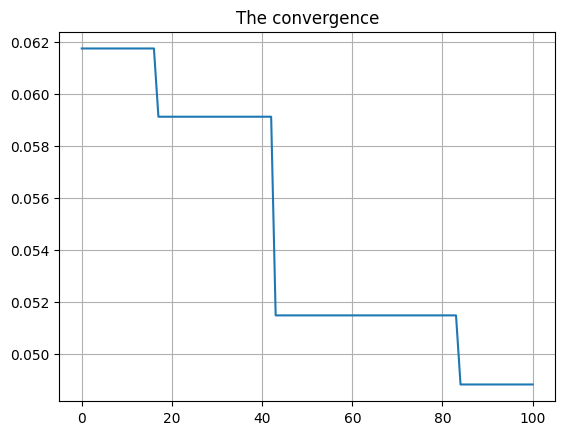

In [19]:
plt.plot(range(len(f_best)), f_best)
plt.title("The convergence")
plt.grid()
plt.savefig("convergence")

Configuration of the best model

In [ ]:
print(f"The best model: {x_best[-1]}")

array([Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
       Softplus(beta=1, threshold=20),
       MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
       30, Sigmoid()], dtype=object)

# Investigate the best model

In [ ]:
# method is created to retrain one specific model
class BestNeuralNetwork(nn.Module):
    def __init__(self, params, ld):
        super(BestNeuralNetwork, self).__init__()
        self.params = params.copy()
        self.ld = ld
         

    def create_directory(self):
        # define the name for the model
        name = "classifier_cnn"

        # Start running CNN process
        #print("\n-> START {}".format(name))

        # Create a folder (REMEMBER: You must mount your drive if you use Colab!)
        if name == "classifier_cnn":
            name = name + "_M_" + str(M) 

        # Create a folder if necessary
        result_dir = os.path.join(results_dir, "results" + name + "/")


        # =========
        # MAKE SURE THAT "result_dir" IS A PATH TO A LOCAL FOLDER OR A GOOGLE COLAB FOLDER (DEFINED IN CELL 3)
        #result_dir = "./"  # (current folder)
        # =========


        if not (os.path.exists(result_dir)):
            #os.mkdir(result_dir)
            os.mkdir(result_dir)
        
        return name, result_dir
    
    def get_size(self, test_loader = test_loader, list_layer = None):

      classnet = nn.Sequential(list_layer[0],
                              list_layer[1],
                              list_layer[2],
                              nn.Flatten())
      to_device(classnet,device)
      
      for indx_batch, (test_batch, test_targets) in enumerate(test_loader):
          x = classnet(test_batch)
          return x.shape[1]

    def run_A_model(self, list_layer=None):
      # create a directory
      name, result_dir = self.create_directory()

      # get size of the flattened vector 
      returned_size = self.get_size(test_loader,list_layer)

      classnet = nn.Sequential(list_layer[0],
                                list_layer[1],
                                list_layer[2],
                                nn.Flatten(),
                                
                                nn.Linear(returned_size,list_layer[3]),
                                list_layer[4],
                                nn.Linear(list_layer[3],10),
                                nn.LogSoftmax(dim=1))


      # Init ClassifierNN
      model = CNNModel(classnet)
      to_device(model, device)

      # Init OPTIMIZER (here we use ADAMAX)
      optimizer = torch.optim.Adamax(
          [p for p in model.parameters() if p.requires_grad == True],
          lr=lr,
          weight_decay=wd,
      )

      # Training procedure
      nll_val, error_val = training(
          name=result_dir + name,
          max_patience=max_patience,
          num_epochs=num_epochs,
          model=model,
          optimizer=optimizer,
          training_loader=train_loader,
          val_loader=val_loader,
      )


      # The final evaluation (on the test set)
      test_loss, test_error = evaluation(name=result_dir + name, test_loader=test_loader)

      # write the results to a file
      f = open(result_dir + name + "_test_loss.txt", "w")
      f.write("NLL: " + str(test_loss) + "\nCE: " + str(test_error))
      f.close()

      # create curves
      plot_curve(
          result_dir + name,
          nll_val,
          file_name="_nll_val_curve.pdf",
          ylabel="nll",
          test_eval=test_loss,
      )
      plot_curve(
          result_dir + name,
          error_val,
          file_name="_ca_val_curve.pdf",
          ylabel="ce",
          color="r-",
          test_eval=test_error,
      )

    
      return test_loss, test_error 

    def run_multiple_time(self, list_layer):
        # create a directory
        name, result_dir = self.create_directory()
        multi_loss, multi_error = [], []
        for i in range(100):

            # get size of the flattened vector 
            returned_size = self.get_size(test_loader,list_layer)

            classnet = nn.Sequential(list_layer[0],
                                    list_layer[1],
                                    list_layer[2],
                                      nn.Flatten(),
                                    
                                      nn.Linear(returned_size,list_layer[3]),
                                      list_layer[4],
                                      nn.Linear(list_layer[3],10),
                                      nn.LogSoftmax(dim=1))


            # Init ClassifierNN
            model = CNNModel(classnet)
            to_device(model, device)

            # Init OPTIMIZER (here we use ADAMAX)
            optimizer = torch.optim.Adamax(
                [p for p in model.parameters() if p.requires_grad == True],
                lr=lr,
                weight_decay=wd,
            )

            # Training procedure
            nll_val, error_val = training(
                name=result_dir + name,
                max_patience=max_patience,
                num_epochs=num_epochs,
                model=model,
                optimizer=optimizer,
                training_loader=train_loader,
                val_loader=val_loader,
            )


            # The final evaluation (on the test set)
            test_loss, test_error = evaluation(name=result_dir + name, test_loader=test_loader)
            multi_loss.append(test_loss)
            multi_error.append(test_error)


        return multi_loss, multi_error 









**The negative log likelihood loss and the classification error** 

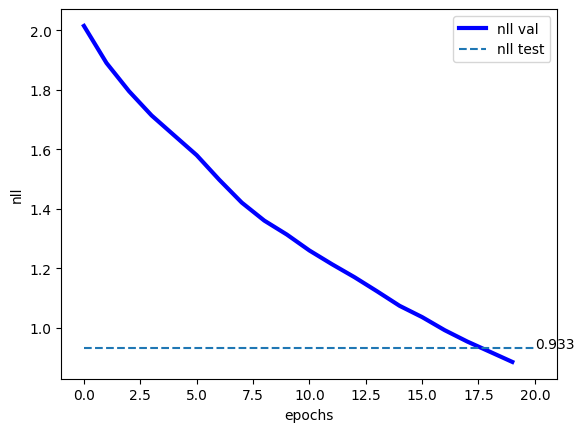

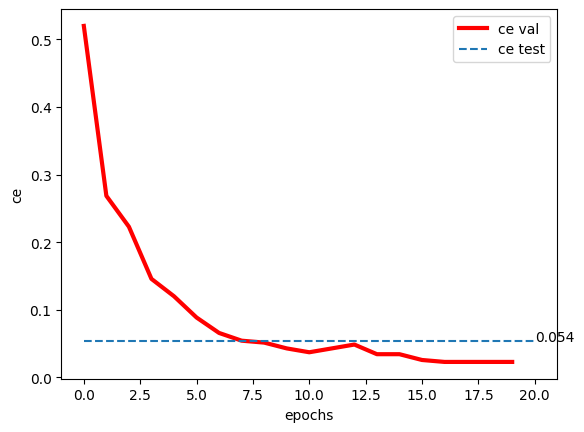

In [ ]:
bestmodel = BestNeuralNetwork(params, ld)
test_loss, test_error = bestmodel.run_A_model(x_best[-1])

In [ ]:
multi_loss, multi_error = bestmodel.run_multiple_time(x_best[-1])

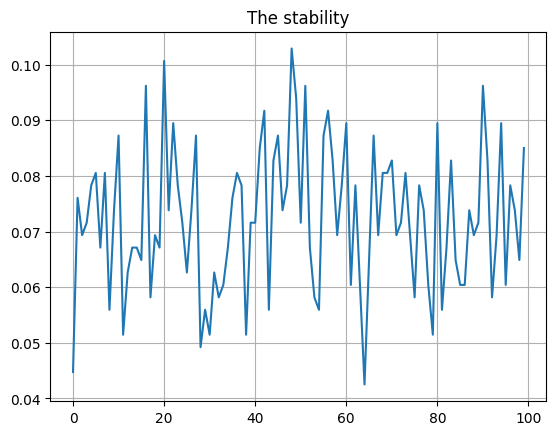

In [ ]:
# plot the stability
plt.plot(range(len(multi_error)), multi_error)
plt.title("The stability of classification error")
plt.grid()
plt.savefig("stable")

In [ ]:
# importing mean() and std()
from statistics import mean

In [ ]:
print(f"The mean classification error: {mean(multi_error)}")
print(f"The standard deviation error: {np.std(multi_error)}")

The mean classification error: 0.07234899328859061
The standard deviation error: 0.012883342399718167
